Бизнес-цели:
1. Для решения задачи регрессии: Предсказать будущую стоимость акций компании Tesla на основе инсайдерских транзакций. Стоимость акций ("Cost") зависит от множества факторов, включая объём и тип транзакций, совершаемых инсайдерами. Если выявить зависимости между параметрами транзакций (количество акций, общий объём сделки, должность инсайдера) и стоимостью акций, это может помочь инвесторам принимать обоснованные решения о покупке или продаже.
2. Для решения задачи классификации: Классифицировать тип инсайдерской транзакции (продажа акций или исполнение опционов) на основе характеристик сделки. Тип транзакции ("Transaction") может быть индикатором доверия инсайдера к текущей рыночной цене или будущей прибыльности компании. Модель, которая предсказывает тип транзакции, может помочь в оценке поведения инсайдеров и выявлении аномалий.

Выгрузка данных из файла в датафрейм

In [1]:
from typing import Any, Tuple
from math import ceil
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt

df: DataFrame = pd.read_csv("static/csv/TSLA.csv")

Преобразование данных

In [2]:
# Преобразование типов данных
df['Insider Trading'] = df['Insider Trading'].astype('category')                             # Преобразование в категорию
df['Relationship'] = df['Relationship'].astype('category')                                   # Преобразование в категорию
df['Transaction'] = df['Transaction'].astype('category')                                     # Преобразование в категорию
df['Cost'] = pd.to_numeric(df['Cost'], errors='coerce')                                      # Преобразование в float
df['Shares'] = pd.to_numeric(df['Shares'].str.replace(',', ''), errors='coerce')             # Преобразование в float без запятых
df['Value ($)'] = pd.to_numeric(df['Value ($)'].str.replace(',', ''), errors='coerce')       # Преобразование в float без запятых
df['Shares Total'] = pd.to_numeric(df['Shares Total'].str.replace(',', ''), errors='coerce') # Преобразование в float без запятых

df['Date'] = pd.to_datetime(df['Date'], errors='coerce') # Преобразование в datetime
df['Year'] = df['Date'].dt.year   # Год
df['Month'] = df['Date'].dt.month # Месяц
df['Day'] = df['Date'].dt.day     # День
df: DataFrame = df.drop(columns=['Date', 'SEC Form 4'])  # Удаление столбцов с датами

print('Выборка данных:')
df.head(10)

Выборка данных:


Insider Trading                    Relationship      Transaction    Cost  \
0  Kirkhorn Zachary         Chief Financial Officer             Sale  196.72   
1    Taneja Vaibhav        Chief Accounting Officer             Sale  195.79   
2  Baglino Andrew D  SVP Powertrain and Energy Eng.             Sale  195.79   
3    Taneja Vaibhav        Chief Accounting Officer  Option Exercise    0.00   
4  Baglino Andrew D  SVP Powertrain and Energy Eng.  Option Exercise    0.00   
5  Kirkhorn Zachary         Chief Financial Officer  Option Exercise    0.00   
6  Baglino Andrew D  SVP Powertrain and Energy Eng.  Option Exercise   20.91   
7  Baglino Andrew D  SVP Powertrain and Energy Eng.             Sale  202.00   
8  Kirkhorn Zachary         Chief Financial Officer             Sale  193.00   
9  Baglino Andrew D  SVP Powertrain and Energy Eng.  Option Exercise   20.91   

   Shares  Value ($)  Shares Total  Year  Month  Day  
0   10455    2056775        203073  2022      3    6  
1    2466     482718        100458  2022      3    6  
2    1298     254232         65547  2022      3    6  
3    7138          0        102923  2022      3    5  
4    2586          0         66845  2022      3    5  
5   16867          0        213528  2022      3    5  
6   10500     219555         74759  2022      2   27  
7   10500    2121000         64259  2022      2   27  
8    3750     723750        196661  2022      2    6  
9   10500     219555         74759  2022      1   27

## Задача регрессии:

Основные метрики для регрессии:
* Средняя абсолютная ошибка (Mean Absolute Error, MAE) – показывает среднее абсолютное отклонение между предсказанными и фактическими значениями. Легко интерпретируется, особенно в финансовых данных, где каждая ошибка в долларах имеет значение.
* Среднеквадратичная ошибка (Mean Squared Error, MSE) – показывает, насколько отклоняются прогнозы модели от истинных значений в квадрате. Подходит для оценки общего качества модели.
* Коэффициент детерминации (R²) – указывает, какую долю дисперсии зависимой переменной объясняет модель. R² варьируется от 0 до 1 (чем ближе к 1, тем лучше).

В качестве базовой модели для оценки качества предсказаний выбрано использование среднего значения целевой переменной (Cost) на обучающей выборке. Это простой и интуитивно понятный метод, который служит минимальным ориентиром для сравнения с более сложными моделями. Базовая модель помогает установить начальный уровень ошибок (MAE, MSE) и показатель качества (R²), которые сложные модели должны улучшить, чтобы оправдать своё использование.

In [3]:
from pandas.core.frame import DataFrame
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Разбить данные на обучающую и тестовую выборки
def split_into_train_test(
    df_input: DataFrame,
    stratify_colname: str = "y",  
    frac_train: float = 0.8,
    random_state: int = 42,
) -> Tuple[DataFrame, DataFrame, DataFrame, DataFrame]:

    if stratify_colname not in df_input.columns:
        raise ValueError("%s is not a column in the dataframe" % (stratify_colname))
    
    if not (0 < frac_train < 1):
        raise ValueError("Fraction must be between 0 and 1.")
    
    X: DataFrame = df_input  # Contains all columns.
    y: DataFrame = df_input[
        [stratify_colname]
    ]  # Dataframe of just the column on which to stratify.

    # Split original dataframe into train and test dataframes.
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=(1.0 - frac_train),
        random_state=random_state
    )
    
    return X_train, X_test, y_train, y_test


# Определяем целевой признак и входные признаки
y_feature: str = 'Cost'
X_features: list[str] = df.drop(columns=y_feature, axis=1).columns.tolist()

# Разбиваем данные на обучающую и тестовую выборки
X_df_train, X_df_test, y_df_train, y_df_test = split_into_train_test(
    df, 
    stratify_colname=y_feature,  
    frac_train=0.8, 
    random_state=42 
)

# Вычисляем предсказания базовой модели (среднее значение целевой переменной)
baseline_predictions: list[float] = [y_df_train.mean()] * len(y_df_test) # type: ignore

# Оцениваем базовую модель
print('Baseline MAE:', mean_absolute_error(y_df_test, baseline_predictions))
print('Baseline MSE:', mean_squared_error(y_df_test, baseline_predictions))
print('Baseline R²:', r2_score(y_df_test, baseline_predictions))

Baseline MAE: 417.78235887096776
Baseline MSE: 182476.07973024843
Baseline R²: -0.027074997920953914


Для обучения были выбраны следующие модели:

1. Случайный лес (Random Forest): Ансамблевая модель, которая использует множество решающих деревьев. Она хорошо справляется с нелинейными зависимостями и шумом в данных, а также обладает устойчивостью к переобучению.
2. Линейная регрессия (Linear Regression): Простая модель, предполагающая линейную зависимость между признаками и целевой переменной. Она быстро обучается и предоставляет легкую интерпретацию результатов.
3. Градиентный бустинг (Gradient Boosting): Мощная модель, создающая ансамбль деревьев, которые корректируют ошибки предыдущих. Эта модель эффективна для сложных наборов данных и обеспечивает высокую точность предсказаний.

Построение конвейера:

In [4]:
from sklearn.impute import SimpleImputer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


# Числовые столбцы
num_columns: list[str] = [
    column
    for column in df.columns
    if df[column].dtype not in ("category", "object")
]

# Категориальные столбцы
cat_columns: list[str] = [
    column
    for column in df.columns
    if df[column].dtype in ("category", "object")
]

# Заполнение пропущенных значений
num_imputer = SimpleImputer(strategy="median")
# Стандартизация
num_scaler = StandardScaler()
# Конвейер для обработки числовых данных
preprocessing_num = Pipeline(
    [
        ("imputer", num_imputer),
        ("scaler", num_scaler),
    ]
)

# Заполнение пропущенных значений
cat_imputer = SimpleImputer(strategy="constant", fill_value="unknown")
# Унитарное кодирование
cat_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop="first")
# Конвейер для обработки категориальных данных
preprocessing_cat = Pipeline(
    [
        ("imputer", cat_imputer),
        ("encoder", cat_encoder),
    ]
)

# Трансформер для предобработки признаков
features_preprocessing = ColumnTransformer(
    verbose_feature_names_out=False,
    transformers=[
        ("prepocessing_num", preprocessing_num, num_columns),
        ("prepocessing_cat", preprocessing_cat, cat_columns),
    ],
    remainder="passthrough"
)

# Основной конвейер предобработки данных
pipeline_end = Pipeline(
    [
        ("features_preprocessing", features_preprocessing),
    ]
)

# Применение конвейера
preprocessing_result = pipeline_end.fit_transform(X_df_train)
preprocessed_df = pd.DataFrame(
    preprocessing_result,
    columns=pipeline_end.get_feature_names_out(),
)

preprocessed_df.head(10)

Cost    Shares  Value ($)  Shares Total      Year     Month       Day  \
0 -0.966516 -0.361759  -0.450022     -0.343599  0.715678 -0.506108 -0.400623   
1 -1.074894  1.225216  -0.414725     -0.319938 -1.397276  0.801338  0.906673   
2 -1.074894  1.211753  -0.415027     -0.320141 -1.397276  1.062828 -0.098939   
3  1.167142  0.037499   1.023612     -0.325853 -1.397276  1.062828 -0.501184   
4  1.217886 -0.075287   0.632973     -0.330205 -1.397276  1.062828 -0.501184   
5  0.505872 -0.361021  -0.443679     -0.343698  0.715678 -0.767598  1.308918   
6 -1.088674 -0.357532  -0.450389     -0.342863  0.715678  0.278360 -0.903429   
7 -0.692146 -0.355855  -0.445383     -0.343220  0.715678  0.801338  1.409480   
8 -1.088674 -0.361181  -0.450389     -0.343649 -1.397276  1.062828 -0.903429   
9  1.091997 -0.204531   0.114712      1.538166  0.715678 -1.029087  1.208357   

   Insider Trading_DENHOLM ROBYN M  Insider Trading_Kirkhorn Zachary  \
0                              0.0                               0.0   
1                              0.0                               0.0   
2                              0.0                               0.0   
3                              0.0                               0.0   
4                              0.0                               0.0   
5                              0.0                               0.0   
6                              0.0                               0.0   
7                              0.0                               0.0   
8                              0.0                               0.0   
9                              0.0                               0.0   

   Insider Trading_Musk Elon  Insider Trading_Musk Kimbal  \
0                        0.0                          0.0   
1                        1.0                          0.0   
2                        1.0                          0.0   
3                        1.0                          0.0   
4                        1.0                          0.0   
5                        0.0                          0.0   
6                        0.0                          0.0   
7                        0.0                          0.0   
8                        0.0                          0.0   
9                        1.0                          0.0   

   Insider Trading_Taneja Vaibhav  Insider Trading_Wilson-Thompson Kathleen  \
0                             1.0                                       0.0   
1                             0.0                                       0.0   
2                             0.0                                       0.0   
3                             0.0                                       0.0   
4                             0.0                                       0.0   
5                             0.0                                       0.0   
6                             1.0                                       0.0   
7                             0.0                                       0.0   
8                             1.0                                       0.0   
9                             0.0                                       0.0   

   Relationship_Chief Accounting Officer  \
0                                    1.0   
1                                    0.0   
2                                    0.0   
3                                    0.0   
4                                    0.0   
5                                    0.0   
6                                    1.0   
7                                    0.0   
8                                    1.0   
9                                    0.0   

   Relationship_Chief Financial Officer  Relationship_Director  \
0                                   0.0                    0.0   
1                                   0.0                    0.0   
2                                   0.0                    0.0   
3                                   0.0   

Обучение моделей:

Оценка результатов обучения:
1. Случайный лес (Random Forest):
    - Показатели:
        - Средний балл: 0.9993.
        - Стандартное отклонение: 0.00046.
    - Вывод: Очень высокая точность, что свидетельствует о хорошей способности модели к обобщению. Низкое значение стандартного отклонения указывает на стабильность модели.
2. Линейная регрессия (Linear Regression):
    - Показатели:
        - Средний балл: 1.0.
        - Стандартное отклонение: 0.0.
    - Вывод: Идеальная точность, однако есть вероятность переобучения, так как стандартное отклонение равно 0. Это может указывать на то, что модель идеально подгоняет данные, но может не работать на новых данных.
3. Градиентный бустинг (Gradient Boosting):
    - Показатели:
        - Средний балл: 0.9998.
        - Стандартное отклонение: 0.00014.
    - Вывод: Отличные результаты с высокой точностью и низкой вариабельностью. Модель также демонстрирует хорошую устойчивость.

In [5]:
# Обучить модели
def train_models(X: DataFrame, y: DataFrame, 
                 models: dict[str, Any]) -> dict[str, dict[str, Any]]:
    results: dict[str, dict[str, Any]] = {}
    
    for model_name, model in models.items():
        # Создание конвейера для текущей модели
        model_pipeline = Pipeline(
            [
                ("features_preprocessing", features_preprocessing),
                ("model", model)
            ]
        )
        
        # Обучаем модель и вычисляем кросс-валидацию
        scores = cross_val_score(model_pipeline, X, y, cv=5) # 5-кратная кросс-валидация
        
        # Вычисление метрик для текущей модели
        metrics_dict: dict[str, Any] = {
            "mean_score": scores.mean(),
            "std_dev": scores.std()
        }
        
        # Сохранениерезультатов
        results[model_name] = metrics_dict
    
    return results


# Выбранные модели для регрессии
models_regression: dict[str, Any] = {
    "Random Forest": RandomForestRegressor(),
    "Linear Regression": LinearRegression(),
    "Gradient Boosting": GradientBoostingRegressor(),
}

results: dict[str, Any] = train_models(X_df_train, y_df_train, models_regression)

# Вывод результатов
for model_name, metrics_dict in results.items():
    print(f"Модель: {model_name}")
    for metric_name, value in metrics_dict.items():
        print(f"\t{metric_name}: {value}")
    print()

e:\aim\aimenv\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
e:\aim\aimenv\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
e:\aim\aimenv\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
e:\aim\aimenv\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
e:\aim\aimenv\L

Модель: Random Forest
	mean_score: 0.9993408296679137
	std_dev: 0.0003334834737331458

Модель: Linear Regression
	mean_score: 1.0
	std_dev: 0.0

Модель: Gradient Boosting
	mean_score: 0.9997626429479803
	std_dev: 0.00014954088559894797



Проверка на тестовом наборе данных:

Оценка результатов обучения:
1. Случайный лес (Random Forest):
    - Показатели:
        - MAE (обучение): 1.858
        - MAE (тест): 4.489
        - MSE (обучение): 10.959
        - MSE (тест): 62.649
        - R² (обучение): 0.9999
        - R² (тест): 0.9997
        - STD (обучение): 3.310
        - STD (тест): 7.757
    - Вывод: Случайный лес показывает великолепные значения R2 на обучающей и тестовой выборках, что свидетельствует о сильной способности к обобщению. Однако MAE и MSE на тестовой выборке значительно выше, чем на обучающей, что может указывать на некоторые проблемы с переобучением.
2. Линейная регрессия (Linear Regression):
    - Показатели:
        - MAE (обучение): 3.069e-13
        - MAE (тест): 2.762e-13
        - MSE (обучение): 1.437e-25
        - MSE (тест): 1.196e-25
        - R² (обучение): 1.0
        - R² (тест): 1.0
        - STD (обучение): 3.730e-13
        - STD (тест): 3.444e-13
    - Вывод: Высокие показатели точности и нулевые ошибки (MAE, MSE) указывают на то, что модель идеально подгоняет данные как на обучающей, так и на тестовой выборках. Однако это также может быть признаком переобучения.
3. Градиентный бустинг (Gradient Boosting):
    - Показатели:
        - MAE (обучение): 0.156
        - MAE (тест): 3.027
        - MSE (обучение): 0.075
        - MSE (тест): 41.360
        - R² (обучение): 0.9999996
        - R² (тест): 0.9998
        - STD (обучение): 0.274
        - STD (тест): 6.399
    - Вывод: Градиентный бустинг демонстрирует отличные результаты на обучающей выборке, однако MAE и MSE на тестовой выборке довольно высокие, что может указывать на определенное переобучение или необходимость улучшения настройки модели.

In [6]:
import numpy as np

from sklearn import metrics


# Оценка качества различных моделей на основе метрик
def evaluate_models(models: dict[str, Any], 
                    pipeline_end: Pipeline, 
                    X_train: DataFrame, y_train, 
                    X_test: DataFrame, y_test) -> dict[str, dict[str, Any]]:
    results: dict[str, dict[str, Any]] = {}
    
    for model_name, model in models.items():
        # Создание конвейера для текущей модели
        model_pipeline = Pipeline(
            [
                ("pipeline", pipeline_end), 
                ("model", model),
            ]
        )
        
        # Обучение текущей модели
        model_pipeline.fit(X_train, y_train)

        # Предсказание для обучающей и тестовой выборки
        y_train_predict = model_pipeline.predict(X_train)
        y_test_predict = model_pipeline.predict(X_test)

        # Вычисление метрик для текущей модели
        metrics_dict: dict[str, Any] = {
            "MAE_train": metrics.mean_absolute_error(y_train, y_train_predict),
            "MAE_test": metrics.mean_absolute_error(y_test, y_test_predict),
            "MSE_train": metrics.mean_squared_error(y_train, y_train_predict),
            "MSE_test": metrics.mean_squared_error(y_test, y_test_predict),
            "R2_train": metrics.r2_score(y_train, y_train_predict),
            "R2_test": metrics.r2_score(y_test, y_test_predict),
            "STD_train": np.std(y_train - y_train_predict),
            "STD_test": np.std(y_test - y_test_predict),
        }

        # Сохранение результатов
        results[model_name] = metrics_dict
    
    return results


y_train = np.ravel(y_df_train)  
y_test = np.ravel(y_df_test) 

results: dict[str, dict[str, Any]] = evaluate_models(models_regression,
                                                     pipeline_end,
                                                     X_df_train, y_train,
                                                     X_df_test, y_test)

# Вывод результатов
for model_name, metrics_dict in results.items():
    print(f"Модель: {model_name}")
    for metric_name, value in metrics_dict.items():
        print(f"\t{metric_name}: {value}")
    print()

Модель: Random Forest
	MAE_train: 1.723261290322547
	MAE_test: 4.921812500000078
	MSE_train: 7.688148654032178
	MSE_test: 71.0254988287519
	R2_train: 0.9999625112378799
	R2_test: 0.9996002297168499
	STD_train: 2.7687940152490023
	STD_test: 8.368380620302354

Модель: Linear Regression
	MAE_train: 3.0690862038154006e-13
	MAE_test: 2.761679773755077e-13
	MSE_train: 1.4370485712253764e-25
	MSE_test: 1.19585889812782e-25
	R2_train: 1.0
	R2_test: 1.0
	STD_train: 3.7295840825107354e-13
	STD_test: 3.4438670391637766e-13

Модель: Gradient Boosting
	MAE_train: 0.15613772760447622
	MAE_test: 3.1034303023675966
	MSE_train: 0.07499640211231746
	MSE_test: 45.07615310256558
	R2_train: 0.9999996343043813
	R2_test: 0.9997462868014123
	STD_train: 0.27385470985965804
	STD_test: 6.690171573523703



Подбор гиперпараметров:

In [7]:
from sklearn.model_selection import GridSearchCV


# Применение конвейера к данным
X_train_processing_result = pipeline_end.fit_transform(X_df_train)
X_test_processing_result = pipeline_end.transform(X_df_test)

# Создание и настройка модели случайного леса
model = RandomForestRegressor()

# Установка параметров для поиска по сетке
param_grid: dict[str, list[int | None]] = {
    'n_estimators': [50, 100, 200],  # Количество деревьев
    'max_depth': [None, 10, 20, 30], # Максимальная глубина дерева
    'min_samples_split': [2, 5, 10]  # Минимальное количество образцов для разбиения узла
}

# Подбор гиперпараметров с помощью поиска по сетке
grid_search = GridSearchCV(estimator=model, 
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=3, n_jobs=-1, verbose=2)

# Обучение модели на тренировочных данных
grid_search.fit(X_train_processing_result, y_train)

# Результаты подбора гиперпараметров
print("Лучшие параметры:", grid_search.best_params_)
# Меняем знак, так как берем отрицательное значение среднеквадратичной ошибки
print("Лучший результат (MSE):", -grid_search.best_score_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Лучшие параметры: {'max_depth': 30, 'min_samples_split': 5, 'n_estimators': 100}
Лучший результат (MSE): 182.9564051380662


Сравнение наборов гиперпараметров:

Результаты анализа показывают, что параметры из старой сетки обеспечивают значительно лучшее качество модели. Среднеквадратическая ошибка (MSE) на кросс-валидации для старых параметров составила 179.369, что существенно ниже, чем для новых параметров (1290.656). На тестовой выборке модель с новыми параметрами показала MSE 172.574, что сопоставимо с результатами модели со старыми параметрами, однако этот результат является случайным, так как новые параметры продемонстрировали плохую кросс-валидационную ошибку, указывая на недообучение. Таким образом, параметры из старой сетки более предпочтительны, так как они обеспечивают лучшее обобщение и меньшую ошибку.

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Старые параметры: {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 50}
Лучший результат (MSE) на старых параметрах: 178.02867772065892

Новые параметры: {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 50}
Лучший результат (MSE) на новых параметрах: 1271.4105559258353
Среднеквадратическая ошибка (MSE) на тестовых данных: 165.739398344422
Корень среднеквадратичной ошибки (RMSE) на тестовых данных: 12.873981448814583


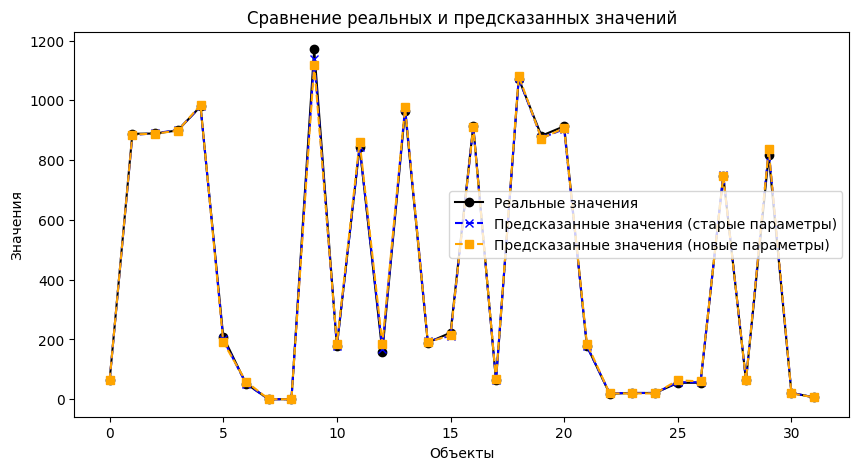

In [8]:
# Установка параметров для поиска по сетке для старых значений
old_param_grid: dict[str, list[int | None]] = {
    'n_estimators': [50, 100, 200],  # Количество деревьев
    'max_depth': [None, 10, 20, 30], # Максимальная глубина дерева
    'min_samples_split': [2, 5, 10]  # Минимальное количество образцов для разбиения узла
}

# Подбор гиперпараметров с помощью поиска по сетке для старых параметров
old_grid_search = GridSearchCV(estimator=model, 
                                param_grid=old_param_grid,
                                scoring='neg_mean_squared_error', cv=3, n_jobs=-1, verbose=2)

# Обучение модели на тренировочных данных
old_grid_search.fit(X_train_processing_result, y_train)

# Результаты подбора для старых параметров
old_best_params = old_grid_search.best_params_
# Меняем знак, так как берем отрицательное значение MSE
old_best_mse = -old_grid_search.best_score_


# Установка параметров для поиска по сетке для новых значений
new_param_grid: dict[str, list[int]] = {
    'n_estimators': [50],
    'max_depth': [5],
    'min_samples_split': [10]
}

# Подбор гиперпараметров с помощью поиска по сетке для новых параметров
new_grid_search = GridSearchCV(estimator=model, 
                                param_grid=new_param_grid,
                                scoring='neg_mean_squared_error', cv=2)

# Обучение модели на тренировочных данных
new_grid_search.fit(X_train_processing_result, y_train)

# Результаты подбора для новых параметров
new_best_params = new_grid_search.best_params_
# Меняем знак, так как берем отрицательное значение MSE
new_best_mse = -new_grid_search.best_score_


# Обучение модели с лучшими параметрами для новых значений
model_best = RandomForestRegressor(**new_best_params)
model_best.fit(X_train_processing_result, y_train)

# Прогнозирование на тестовой выборке
y_pred = model_best.predict(X_test_processing_result)

# Оценка производительности модели
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)


# Вывод результатов
print("Старые параметры:", old_best_params)
print("Лучший результат (MSE) на старых параметрах:", old_best_mse)
print("\nНовые параметры:", new_best_params)
print("Лучший результат (MSE) на новых параметрах:", new_best_mse)
print("Среднеквадратическая ошибка (MSE) на тестовых данных:", mse)
print("Корень среднеквадратичной ошибки (RMSE) на тестовых данных:", rmse)

# Обучение модели с лучшими параметрами для старых значений
model_old = RandomForestRegressor(**old_best_params)
model_old.fit(X_train_processing_result, y_train)

# Прогнозирование на тестовой выборке для старых параметров
y_pred_old = model_old.predict(X_test_processing_result)

# Визуализация ошибок
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Реальные значения', marker='o', linestyle='-', color='black')
plt.plot(y_pred_old, label='Предсказанные значения (старые параметры)', marker='x', linestyle='--', color='blue')
plt.plot(y_pred, label='Предсказанные значения (новые параметры)', marker='s', linestyle='--', color='orange')
plt.xlabel('Объекты')
plt.ylabel('Значения')
plt.title('Сравнение реальных и предсказанных значений')
plt.legend()
plt.show()

## Задача классификации:

Основные метрики для классификации:
- Accuracy (точность) – показывает долю правильно классифицированных примеров среди всех наблюдений. Легко интерпретируется, но может быть недостаточно информативной для несбалансированных классов.
- F1-Score – гармоническое среднее между точностью (precision) и полнотой (recall). Подходит для задач, где важно одновременно учитывать как ложные положительные, так и ложные отрицательные ошибки, особенно при несбалансированных классах.
- ROC AUC (Area Under the ROC Curve) – отражает способность модели различать положительные и отрицательные классы на всех уровнях порога вероятности. Значение от 0.5 (случайное угадывание) до 1.0 (идеальная модель). Полезна для оценки модели на несбалансированных данных.
- Cohen's Kappa – измеряет степень согласия между предсказаниями модели и истинными метками с учётом случайного угадывания. Значения варьируются от -1 (полное несогласие) до 1 (идеальное согласие). Удобна для оценки на несбалансированных данных.
- MCC (Matthews Correlation Coefficient) – метрика корреляции между предсказаниями и истинными классами, учитывающая все типы ошибок (TP, TN, FP, FN). Значение варьируется от -1 (полная несоответствие) до 1 (идеальное совпадение). Отлично подходит для задач с несбалансированными классами.
- Confusion Matrix (матрица ошибок) – матрица ошибок отражает распределение предсказаний модели по каждому из классов.

Разбиение данных

In [9]:
from sklearn.metrics import accuracy_score, f1_score


# Определяем целевой признак и входные признаки
y_feature: str = 'Transaction'
X_features: list[str] = df.drop(columns=y_feature, axis=1).columns.tolist()

# Разбиваем данные на обучающую и тестовую выборки
X_df_train, X_df_test, y_df_train, y_df_test = split_into_train_test(
    df, 
    stratify_colname=y_feature,  
    frac_train=0.8, 
    random_state=42 
)

# Определяем самый частый класс
most_frequent_class = y_df_train.mode().values[0][0]
print(f"Самый частый класс: {most_frequent_class}")

# Вычисляем предсказания базовой модели (все предсказания равны самому частому классу)
baseline_predictions: list[str] = [most_frequent_class] * len(y_df_test)

# Оцениваем базовую модель
print('Baseline Accuracy:', accuracy_score(y_df_test, baseline_predictions))
print('Baseline F1:', f1_score(y_df_test, baseline_predictions, average='weighted'))

# Унитарное кодирование для целевого признака
y_df_train = y_df_train['Transaction'].map({'Sale': 1, 'Option Exercise': 0})
y_df_test = y_df_test['Transaction'].map({'Sale': 1, 'Option Exercise': 0})

Самый частый класс: Sale
Baseline Accuracy: 0.59375
Baseline F1: 0.4424019607843137


Выбор моделей обучения:

Для обучения были выбраны следующие модели:
1. **Случайный лес (Random Forest)**: Ансамблевая модель, которая использует множество решающих деревьев. Она хорошо справляется с нелинейными зависимостями и шумом в данных, а также обладает устойчивостью к переобучению.
2. **Логистическая регрессия (Logistic Regression)**: Статистический метод для бинарной классификации, который моделирует зависимость между целевой переменной и независимыми признаками, используя логистическую функцию. Она проста в интерпретации и быстра в обучении.
3. **Метод ближайших соседей (KNN)**: Алгоритм классификации, который предсказывает класс на основе ближайших k обучающих примеров. KNN интуитивно понятен и не требует обучения, но может быть медленным на больших данных и чувствительным к выбору параметров.

Конвейеры для обработки числовых и категориальных значений, а так же основной конвейер уже были построены ранее при решении задачи регрессии.

In [10]:
# Применение конвейера
preprocessing_result = pipeline_end.fit_transform(X_df_train)
preprocessed_df = pd.DataFrame(
    preprocessing_result,
    columns=pipeline_end.get_feature_names_out(),
)

preprocessed_df.head(10)

Cost    Shares  Value ($)  Shares Total      Year     Month       Day  \
0 -0.966516 -0.361759  -0.450022     -0.343599  0.715678 -0.506108 -0.400623   
1 -1.074894  1.225216  -0.414725     -0.319938 -1.397276  0.801338  0.906673   
2 -1.074894  1.211753  -0.415027     -0.320141 -1.397276  1.062828 -0.098939   
3  1.167142  0.037499   1.023612     -0.325853 -1.397276  1.062828 -0.501184   
4  1.217886 -0.075287   0.632973     -0.330205 -1.397276  1.062828 -0.501184   
5  0.505872 -0.361021  -0.443679     -0.343698  0.715678 -0.767598  1.308918   
6 -1.088674 -0.357532  -0.450389     -0.342863  0.715678  0.278360 -0.903429   
7 -0.692146 -0.355855  -0.445383     -0.343220  0.715678  0.801338  1.409480   
8 -1.088674 -0.361181  -0.450389     -0.343649 -1.397276  1.062828 -0.903429   
9  1.091997 -0.204531   0.114712      1.538166  0.715678 -1.029087  1.208357   

   Insider Trading_DENHOLM ROBYN M  Insider Trading_Kirkhorn Zachary  \
0                              0.0                               0.0   
1                              0.0                               0.0   
2                              0.0                               0.0   
3                              0.0                               0.0   
4                              0.0                               0.0   
5                              0.0                               0.0   
6                              0.0                               0.0   
7                              0.0                               0.0   
8                              0.0                               0.0   
9                              0.0                               0.0   

   Insider Trading_Musk Elon  Insider Trading_Musk Kimbal  \
0                        0.0                          0.0   
1                        1.0                          0.0   
2                        1.0                          0.0   
3                        1.0                          0.0   
4                        1.0                          0.0   
5                        0.0                          0.0   
6                        0.0                          0.0   
7                        0.0                          0.0   
8                        0.0                          0.0   
9                        1.0                          0.0   

   Insider Trading_Taneja Vaibhav  Insider Trading_Wilson-Thompson Kathleen  \
0                             1.0                                       0.0   
1                             0.0                                       0.0   
2                             0.0                                       0.0   
3                             0.0                                       0.0   
4                             0.0                                       0.0   
5                             0.0                                       0.0   
6                             1.0                                       0.0   
7                             0.0                                       0.0   
8                             1.0                                       0.0   
9                             0.0                                       0.0   

   Relationship_Chief Accounting Officer  \
0                                    1.0   
1                                    0.0   
2                                    0.0   
3                                    0.0   
4                                    0.0   
5                                    0.0   
6                                    1.0   
7                                    0.0   
8                                    1.0   
9                                    0.0   

   Relationship_Chief Financial Officer  Relationship_Director  \
0                                   0.0                    0.0   
1                                   0.0                    0.0   
2                                   0.0                    0.0   
3                                   0.0   

Оценка результатов обучения:
1. **Случайный лес (Random Forest)**:
    - Показатели:
        - Precision (обучение): 1.0
        - Precision (тест): 1.0
        - Recall (обучение): 1.0
        - Recall (тест): 1.0
        - Accuracy (обучение): 1.0
        - Accuracy (тест): 1.0
        - F1 Score (обучение): 1.0
        - F1 Score (тест): 1.0
        - ROC AUC (тест): 1.0
        - Cohen Kappa (тест): 1.0
        - MCC (тест): 1.0
        - Confusion Matrix (тест):
          ```
          [[13,  0],
           [ 0, 19]]
          ```
    - Вывод: Случайный лес идеально справляется с задачей на обеих выборках. Однако столь высокие значения метрик на обучении и тесте могут указывать на переобучение модели.
2. **Логистическая регрессия (Logistic Regression)**:
    - Показатели:
        - Precision (обучение): 1.0
        - Precision (тест): 1.0
        - Recall (обучение): 1.0
        - Recall (тест): 1.0
        - Accuracy (обучение): 1.0
        - Accuracy (тест): 1.0
        - F1 Score (обучение): 1.0
        - F1 Score (тест): 1.0
        - ROC AUC (тест): 1.0
        - Cohen Kappa (тест): 1.0
        - MCC (тест): 1.0
        - Confusion Matrix (тест):
          ```
          [[13,  0],
           [ 0, 19]]
          ```
    - Вывод: Логистическая регрессия также показывает идеальные результаты. Это может быть связано с линейной разделимостью данных.
3. **Метод ближайших соседей (KNN)**:
    - Показатели:
        - Precision (обучение): 1.0
        - Precision (тест): 1.0
        - Recall (обучение): 0.95
        - Recall (тест): 0.947
        - Accuracy (обучение): 0.968
        - Accuracy (тест): 0.969
        - F1 Score (обучение): 0.974
        - F1 Score (тест): 0.973
        - ROC AUC (тест): 0.974
        - Cohen Kappa (тест): 0.936
        - MCC (тест): 0.938
        - Confusion Matrix (тест):
          ```
          [[13,  0],
           [ 1, 18]]
          ```
    - Вывод: Метод ближайших соседей показывает хорошие результаты, с небольшим снижением полноты на тестовой выборке. Это связано с особенностями алгоритма, который может быть чувствителен к выбросам и распределению данных.

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics


# Оценка качества различных моделей на основе метрик
def evaluate_models(models: dict[str, Any], 
                    pipeline_end: Pipeline, 
                    X_train: DataFrame, y_train, 
                    X_test: DataFrame, y_test) -> dict[str, dict[str, Any]]:
    results: dict[str, dict[str, Any]] = {}
    
    for model_name, model in models.items():
        # Создание конвейера для текущей модели
        model_pipeline = Pipeline(
            [
                ("pipeline", pipeline_end), 
                ("model", model),
            ]
        )
        
        # Обучение модели
        model_pipeline.fit(X_train, y_train)
        
        # Предсказание для обучающей и тестовой выборки
        y_train_predict = model_pipeline.predict(X_train)
        y_test_predict = model_pipeline.predict(X_test)
        
        # Вычисление метрик для текущей модели
        metrics_dict: dict[str, Any] = {
            "Precision_train": metrics.precision_score(y_train, y_train_predict),
            "Precision_test": metrics.precision_score(y_test, y_test_predict),
            "Recall_train": metrics.recall_score(y_train, y_train_predict),
            "Recall_test": metrics.recall_score(y_test, y_test_predict),
            "Accuracy_train": metrics.accuracy_score(y_train, y_train_predict),
            "Accuracy_test": metrics.accuracy_score(y_test, y_test_predict),
            "F1_train": metrics.f1_score(y_train, y_train_predict),
            "F1_test": metrics.f1_score(y_test, y_test_predict),
            "ROC_AUC_test": metrics.roc_auc_score(y_test, y_test_predict),
            "Cohen_kappa_test": metrics.cohen_kappa_score(y_test, y_test_predict),
            "MCC_test": metrics.matthews_corrcoef(y_test, y_test_predict),
            "Confusion_matrix": metrics.confusion_matrix(y_test, y_test_predict),
        }
        
        # Сохранение результатов
        results[model_name] = metrics_dict
    
    return results


# Выбранные модели для классификации
models_classification: dict[str, Any] = {
    "RandomForestClassifier": RandomForestClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
}

results: dict[str, dict[str, Any]] = evaluate_models(models_classification,
                                                     pipeline_end,
                                                     X_df_train, y_df_train,
                                                     X_df_test, y_df_test)

# Вывод результатов
for model_name, metrics_dict in results.items():
    print(f"Модель: {model_name}")
    for metric_name, value in metrics_dict.items():
        print(f"\t{metric_name}: {value}")
    print()

Модель: RandomForestClassifier
	Precision_train: 1.0
	Precision_test: 1.0
	Recall_train: 1.0
	Recall_test: 1.0
	Accuracy_train: 1.0
	Accuracy_test: 1.0
	F1_train: 1.0
	F1_test: 1.0
	ROC_AUC_test: 1.0
	Cohen_kappa_test: 1.0
	MCC_test: 1.0
	Confusion_matrix: [[13  0]
 [ 0 19]]

Модель: LogisticRegression
	Precision_train: 1.0
	Precision_test: 1.0
	Recall_train: 1.0
	Recall_test: 1.0
	Accuracy_train: 1.0
	Accuracy_test: 1.0
	F1_train: 1.0
	F1_test: 1.0
	ROC_AUC_test: 1.0
	Cohen_kappa_test: 1.0
	MCC_test: 1.0
	Confusion_matrix: [[13  0]
 [ 0 19]]

Модель: KNN
	Precision_train: 1.0
	Precision_test: 1.0
	Recall_train: 0.95
	Recall_test: 0.9473684210526315
	Accuracy_train: 0.967741935483871
	Accuracy_test: 0.96875
	F1_train: 0.9743589743589743
	F1_test: 0.972972972972973
	ROC_AUC_test: 0.9736842105263157
	Cohen_kappa_test: 0.9359999999999999
	MCC_test: 0.9379228369755696
	Confusion_matrix: [[13  0]
 [ 1 18]]



e:\aim\aimenv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Не удается найти указанный файл
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "e:\aim\aimenv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\Владимир\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Владимир\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\Владимир\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", li

Матрица ошибок:

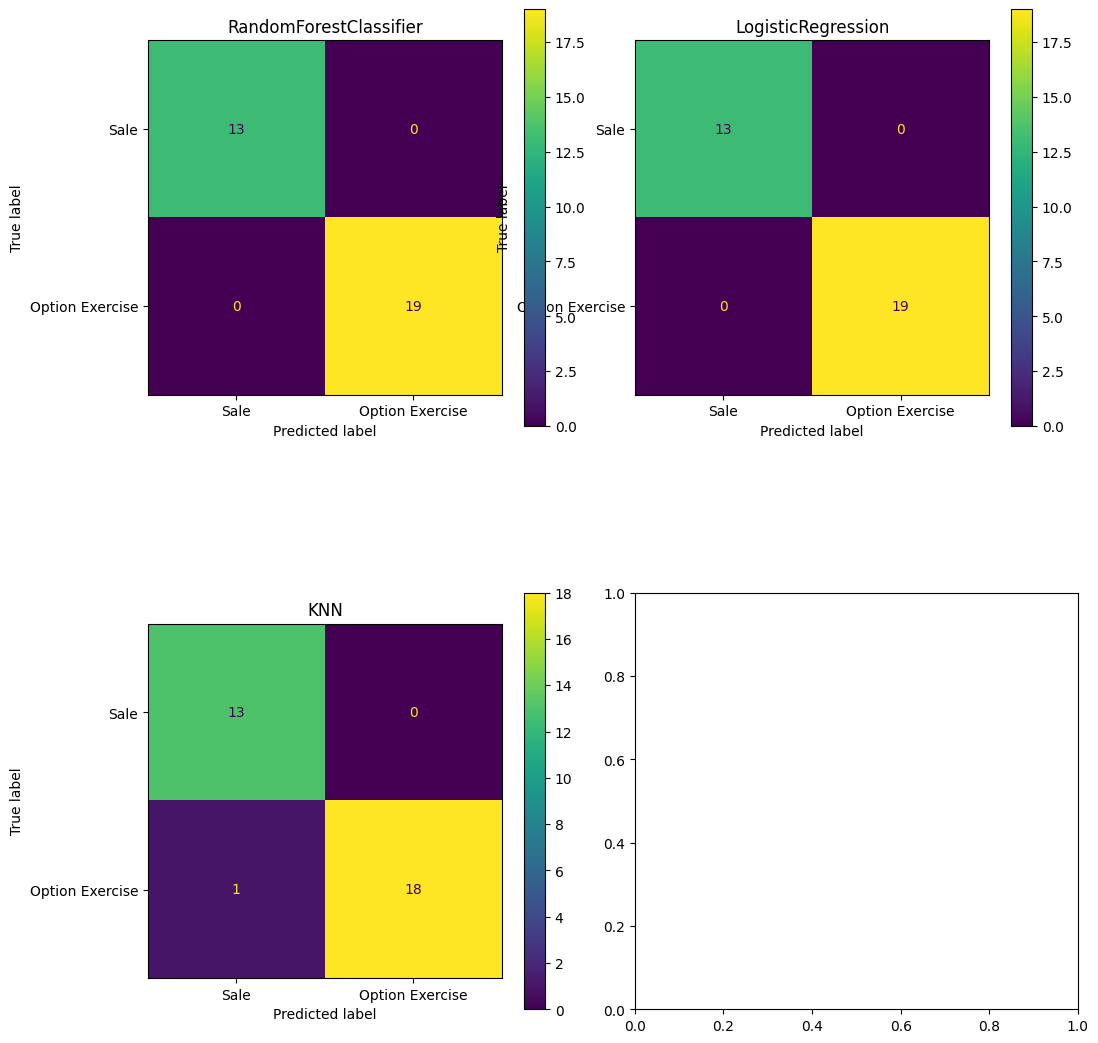

In [12]:
from sklearn.metrics import ConfusionMatrixDisplay

_, ax = plt.subplots(ceil(len(models_classification) / 2), 2, figsize=(12, 10), sharex=False, sharey=False)

for index, key in enumerate(models_classification.keys()):
  c_matrix = results[key]["Confusion_matrix"]
  disp = ConfusionMatrixDisplay(
    confusion_matrix=c_matrix, display_labels=["Sale", "Option Exercise"]
  ).plot(ax=ax.flat[index])
  disp.ax_.set_title(key)

plt.subplots_adjust(top=1, bottom=0, hspace=0.4, wspace=0.1)
plt.show()

Подбор гиперпараметров:

In [13]:
# Создание конвейера
pipeline = Pipeline([
    ("processing", pipeline_end),
    ("model", RandomForestClassifier(random_state=42))
])

# Установка параметров для поиска по сетке
param_grid: dict[str, Any] = {
    "model__n_estimators": [10, 50, 100],
    "model__max_features": ["sqrt", "log2"],
    "model__max_depth": [5, 7, 10],
    "model__criterion": ["gini", "entropy"],
}

# Подбор гиперпараметров с помощью поиска по сетке
grid_search = GridSearchCV(estimator=pipeline, 
                           param_grid=param_grid,
                           n_jobs=-1)

# Обучение модели на тренировочных данных
grid_search.fit(X_df_train, y_df_train)

# Результаты подбора гиперпараметров
print("Лучшие параметры:", grid_search.best_params_)

Лучшие параметры: {'model__criterion': 'gini', 'model__max_depth': 5, 'model__max_features': 'sqrt', 'model__n_estimators': 10}


e:\aim\aimenv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Сравнение наборов гиперпараметров:

Результаты анализа показывают, что как стоковая модель, так и оптимизированная модель демонстрируют идентичные показатели качества, включая абсолютные значения всех ключевых метрик (Precision, Recall, Accuracy, F1-Score и другие), равные 1.0 на обеих выборках (обучающей и тестовой). Это указывает на то, что обе модели идеально справляются с задачей классификации.

In [14]:
# Обучение модели со старыми гипермараметрами
pipeline.fit(X_df_train, y_df_train)

# Предсказание для обучающей и тестовой выборки
y_train_predict = pipeline.predict(X_df_train)
y_test_predict = pipeline.predict(X_df_test)
        
# Вычисление метрик для модели со старыми гипермараметрами
base_model_metrics: dict[str, Any] = {
    "Precision_train": metrics.precision_score(y_df_train, y_train_predict),
    "Precision_test": metrics.precision_score(y_df_test, y_test_predict),
    "Recall_train": metrics.recall_score(y_df_train, y_train_predict),
    "Recall_test": metrics.recall_score(y_df_test, y_test_predict),
    "Accuracy_train": metrics.accuracy_score(y_df_train, y_train_predict),
    "Accuracy_test": metrics.accuracy_score(y_df_test, y_test_predict),
    "F1_train": metrics.f1_score(y_df_train, y_train_predict),
    "F1_test": metrics.f1_score(y_df_test, y_test_predict),
    "ROC_AUC_test": metrics.roc_auc_score(y_df_test, y_test_predict),
    "Cohen_kappa_test": metrics.cohen_kappa_score(y_df_test, y_test_predict),
    "MCC_test": metrics.matthews_corrcoef(y_df_test, y_test_predict),
    "Confusion_matrix": metrics.confusion_matrix(y_df_test, y_test_predict),
}

# Модель с новыми гипермараметрами
optimized_model = RandomForestClassifier(
    random_state=42,
    criterion="gini",
    max_depth=5,
    max_features="sqrt",
    n_estimators=10,
)

# Создание конвейера для модели с новыми гипермараметрами
optimized_model_pipeline = Pipeline(
    [
        ("pipeline", pipeline_end), 
        ("model", optimized_model),
    ]
)
        
# Обучение модели с новыми гипермараметрами
optimized_model_pipeline.fit(X_df_train, y_df_train)
        
# Предсказание для обучающей и тестовой выборки
y_train_predict = optimized_model_pipeline.predict(X_df_train)
y_test_predict = optimized_model_pipeline.predict(X_df_test)
        
# Вычисление метрик для модели с новыми гипермараметрами
optimized_model_metrics: dict[str, Any] = {
    "Precision_train": metrics.precision_score(y_df_train, y_train_predict),
    "Precision_test": metrics.precision_score(y_df_test, y_test_predict),
    "Recall_train": metrics.recall_score(y_df_train, y_train_predict),
    "Recall_test": metrics.recall_score(y_df_test, y_test_predict),
    "Accuracy_train": metrics.accuracy_score(y_df_train, y_train_predict),
    "Accuracy_test": metrics.accuracy_score(y_df_test, y_test_predict),
    "F1_train": metrics.f1_score(y_df_train, y_train_predict),
    "F1_test": metrics.f1_score(y_df_test, y_test_predict),
    "ROC_AUC_test": metrics.roc_auc_score(y_df_test, y_test_predict),
    "Cohen_kappa_test": metrics.cohen_kappa_score(y_df_test, y_test_predict),
    "MCC_test": metrics.matthews_corrcoef(y_df_test, y_test_predict),
    "Confusion_matrix": metrics.confusion_matrix(y_df_test, y_test_predict),
}

# Вывод информации
print('Стоковая модель:')
for metric_name, value in base_model_metrics.items():
    print(f"\t{metric_name}: {value}")

print('\nОптимизированная модель:')
for metric_name, value in optimized_model_metrics.items():
    print(f"\t{metric_name}: {value}")

Стоковая модель:
	Precision_train: 1.0
	Precision_test: 1.0
	Recall_train: 1.0
	Recall_test: 1.0
	Accuracy_train: 1.0
	Accuracy_test: 1.0
	F1_train: 1.0
	F1_test: 1.0
	ROC_AUC_test: 1.0
	Cohen_kappa_test: 1.0
	MCC_test: 1.0
	Confusion_matrix: [[13  0]
 [ 0 19]]

Оптимизированная модель:
	Precision_train: 1.0
	Precision_test: 1.0
	Recall_train: 1.0
	Recall_test: 1.0
	Accuracy_train: 1.0
	Accuracy_test: 1.0
	F1_train: 1.0
	F1_test: 1.0
	ROC_AUC_test: 1.0
	Cohen_kappa_test: 1.0
	MCC_test: 1.0
	Confusion_matrix: [[13  0]
 [ 0 19]]
